# ECG Signal Processing and Analysis

Use the following code to download the standard ECG dataset from SciPy:

```python
from scipy import datasets
ecg = datasets.electrocardiogram()
```
From the SciPy documentation:
```
The returned signal is a 5 minute long electrocardiogram (ECG), a medical recording of the heart’s electrical activity, sampled at 360 Hz.
The provided signal is an excerpt (19:35 to 24:35) from the record 208 (lead MLII) provided by the MIT-BIH Arrhythmia Database [1] on PhysioNet [2].
The excerpt includes noise induced artifacts, typical heartbeats as well as pathological changes.
```

In [2]:
!pip install pooch


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Step 0: Load & Plot the Data

In [3]:
from scipy import datasets
import matplotlib.pyplot as plt
import numpy as np

In [4]:
ecg = datasets.electrocardiogram()

In [5]:
fs = 360.0
tvec = np.array([k / fs for k in range(len(ecg))])
tvec[:5]

array([0.        , 0.00277778, 0.00555556, 0.00833333, 0.01111111])

In [6]:
nfft = 4 * len(ecg)
freqvec = np.array([(k - nfft / 2) * fs / nfft for k in range(nfft)])
freqvec[:5]

array([-180.        , -179.99916667, -179.99833333, -179.9975    ,
       -179.99666667])

In [7]:
def compute_magnitude_response_dB(x, nfft):
    Xk = 20.0 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(x, nfft))))
    return Xk

In [8]:
# Calculate the magnitude response, in dB
Xk = compute_magnitude_response_dB(ecg, nfft)
Xk[:5]

array([5.82293523, 7.68749273, 9.47343454, 8.88080171, 4.66216625])

### Time & Frequency-Domain Plots

Text(0.5, 1.0, 'Magnitude Response')

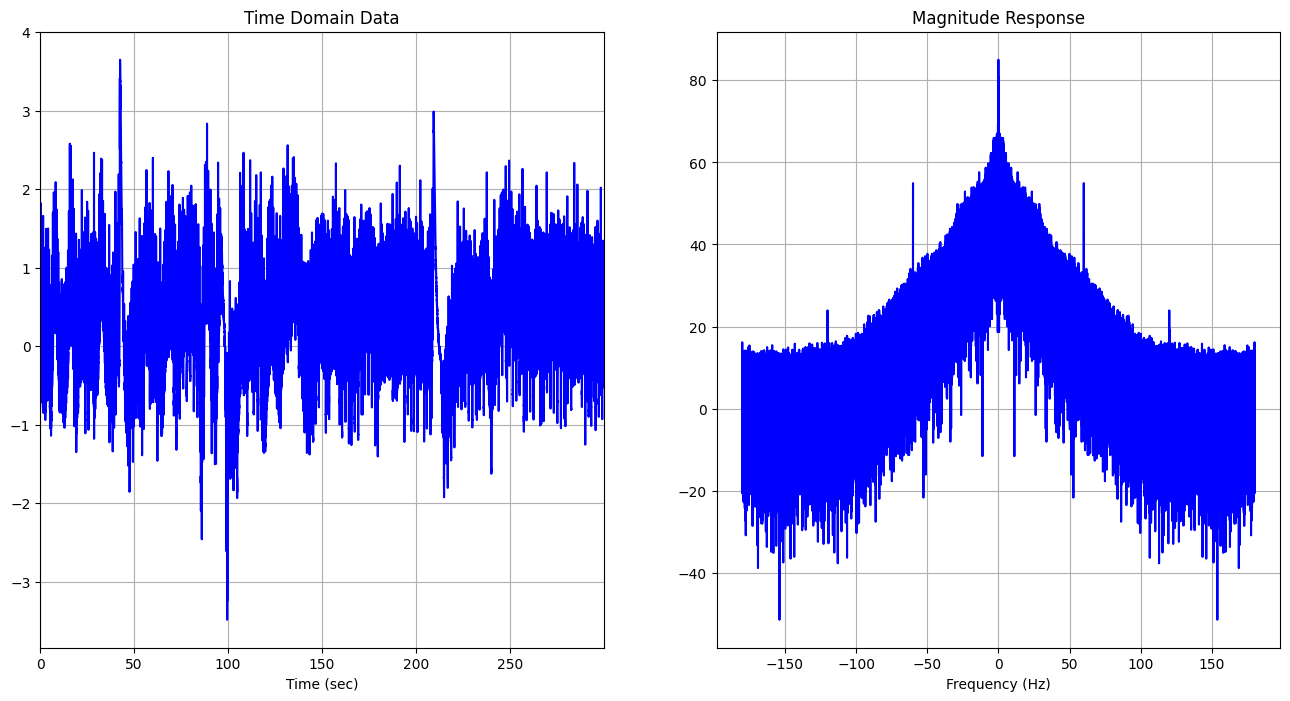

In [9]:
_, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(tvec, ecg, color="blue")
ax[0].grid(True)
ax[0].set_xlim([0, tvec[-1]])
ax[0].set_xlabel("Time (sec)")
ax[0].set_title("Time Domain Data")

ax[1].plot(freqvec, Xk, label="Unfiltered Signal", color="blue")
ax[1].grid(True)
# ax[1].set_xlim([0, fs/2])
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_title("Magnitude Response")

## Step 1: Noise reduction

1. Reduce the noise.
2. Quantify the improvement in SNR an plot the filtered signal.

### Filter Design

In [10]:
def plot_response(filter_coefs, fs, title):
    "Utility function to plot response functions"
    w, h = signal.freqz(filter_coefs, [1], worN=2000, fs=fs)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(w, 20 * np.log10(np.abs(h)))
    ax.set_ylim(-150, 5)
    ax.grid(True)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Gain (dB)")
    ax.set_title(title)

In [11]:
from scipy import signal

#### Low Pass

In [12]:
cutoff = 25  # Desired cutoff frequency, Hz
trans_width = 5  # Width of transition from pass to stop, Hz
numtaps = 325  # Size of the FIR filter
lp_filter_coefs = signal.remez(
    numtaps, [0, cutoff, cutoff + trans_width, 0.5 * fs], [1, 0], fs=fs
)

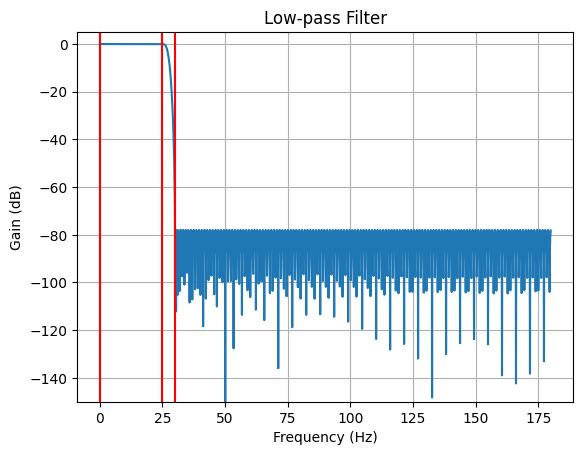

In [13]:
plot_response(lp_filter_coefs, fs, "Low-pass Filter")
plt.vlines([0, cutoff, cutoff + trans_width], ymin=-150, ymax=5, colors="r")
plt.show()

### Filter the Signal

Remove the group delay of the filter. For an FIR filter, the group delay is (n - 1)/2

In [93]:
filter_coefs = lp_filter_coefs
padded_ecg = np.zeros((len(ecg) + len(filter_coefs),))
padded_ecg[: len(ecg)] = ecg
group_delay = int((len(filter_coefs) - 1) / 2)
filtered_ecg = signal.lfilter(filter_coefs, [1.0], padded_ecg)[
    group_delay : group_delay + len(ecg)
]
filtered_ecg[:5]

array([-0.11905922, -0.14110174, -0.15902452, -0.17228593, -0.18098786])

### Repeat the Plots

With the filtered signals on top

In [94]:
filtered_Xk = compute_magnitude_response_dB(filtered_ecg, nfft)
filter_magnitude_response = compute_magnitude_response_dB(filter_coefs * sum(ecg), nfft)

Text(0.5, 0, 'Frequency (Hz)')

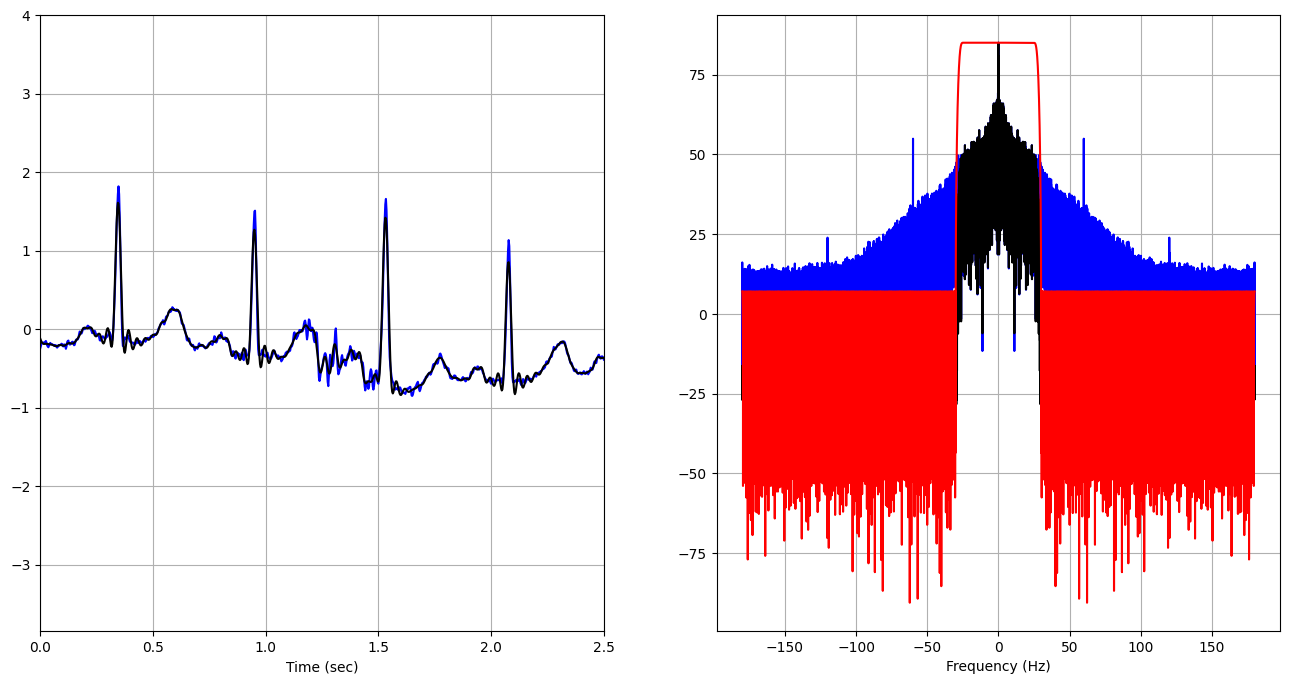

In [95]:
_, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(tvec, ecg, color="blue")
ax[0].plot(tvec, filtered_ecg, color="black")
ax[0].grid(True)
ax[0].set_xlim([0, tvec[-1]])
# just plot the first few seconds to see the obvious heartbeats
ax[0].set_xlim([0.0, 2.5])
ax[0].set_xlabel("Time (sec)")

ax[1].plot(freqvec, Xk, label="Unfiltered Signal", color="blue")
ax[1].plot(freqvec, filtered_Xk, label="Filtered Signal", color="black")
ax[1].plot(freqvec, filter_magnitude_response, label="Filtered", color="red")
ax[1].grid(True)
# ax[1].set_xlim(np.array([-1, 1])*2)
# ax[1].set_ylim([-100, 5])
ax[1].set_xlabel("Frequency (Hz)")

### SNR Improvement

Declare the filtered content (in the stopbands of the filter) to be entirely noise
- Then the delta SNR = power sum before filtering / power sum after filtering

In [96]:
delta_snr_dB = 10.0 * np.log10(np.sum(ecg**2) / np.sum(filtered_ecg**2))
delta_snr_dB

np.float64(0.04369822695329033)

The SNR improvement is negligible

## Step 2: Peak Detection

1. **Identify the peaks (heartbeats)** in the filtered ECG signal.
2. Implement a **real-time peak detection algorithm**.
3. Count the **total number of peaks** and calculate the **heart rate** in beats per minute (BPM).

Look for local maxima as those where the first difference exceeds a threshold

In [ ]:
first_diff_thresh = 0.15  # by inspection

(0.0, 5.0)

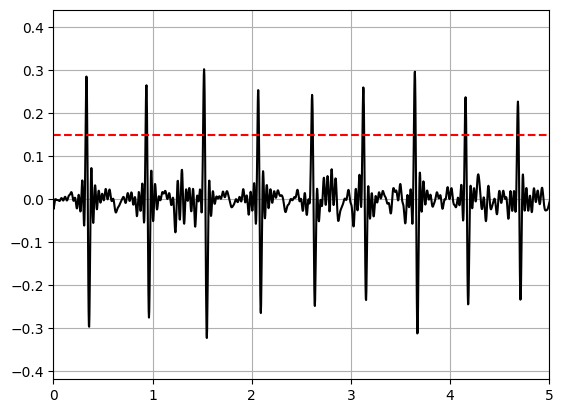

In [198]:
plt.plot(tvec, d1_filtered_ecg, color="black")
plt.grid(True)
plt.hlines([first_diff_thresh], xmin=0.0, xmax=tvec[-1], colors="r", ls="--")
plt.xlim([0, 5])

In [206]:
d1_filtered_ecg = np.diff(filtered_ecg)
d1_filtered_ecg = np.pad(d1_filtered_ecg, (1, 0), mode="constant", constant_values=0)
is_peak_mask = d1_filtered_ecg > first_diff_thresh
d1_filtered_ecg[:5]

array([ 0.        , -0.02204252, -0.01792278, -0.01326142, -0.00870193])

In [207]:
peak_inds = np.nonzero(is_peak_mask)[0]
peak_inds[:10]

array([117, 118, 119, 120, 121, 122, 123, 335, 336, 337])

For each candidate peak, eliminate near neighbors
- Only retain those peaks which are the largest in a neighborhood

In [269]:
half_window_width = (
    21  # samples - choose based on something like expected period, in samples
)
for k in peak_inds:
    is_local_max = np.all(
        d1_filtered_ecg[k]
        >= d1_filtered_ecg[k - half_window_width : k + half_window_width]
    )
    if not is_local_max:
        print(
            f"Dropping peak at index k = {k}, "
            + f"considering samples {k - half_window_width}"
            + f" to {k + half_window_width}"
        )
    is_peak_mask[k] = is_local_max

In [268]:
peak_inds = np.nonzero(is_peak_mask)[0]
peak_inds[:10]

array([ 120,  338,  547,  744,  939, 1125, 1312, 1496, 1686, 1875])

In [210]:
total_heartbeats = len(peak_inds)
total_heartbeats

396

In [211]:
heartbeats_per_second = float(total_heartbeats / tvec[-1])
heartbeats_per_second

1.320012222335392

In [212]:
heartbeat_period = 1.0 / num_heartbeats_per_second  # seconds per heartbeat
heartbeat_period

0.7575687429854097

In [213]:
heartbeats_per_minute = heartbeats_per_second * 60.0  # AKA bpm
heartbeats_per_minute

79.20073334012352

### Solutions

There are approximately **396 total heartbeats**, and an average heartrate of **79 beats per minute**

(0.0, 3.0)

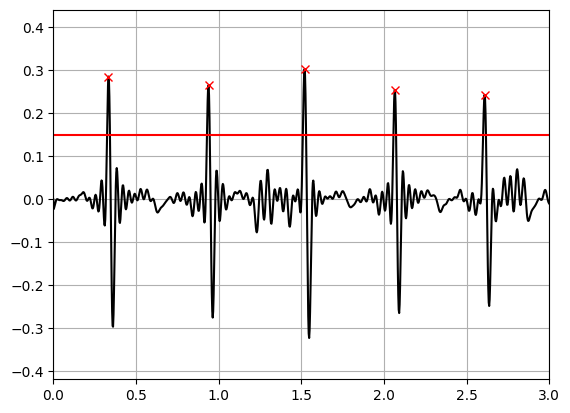

In [176]:
plt.plot(tvec, d1_filtered_ecg, color="black")
plt.plot(tvec[peak_inds], d1_filtered_ecg[peak_inds], "x", color="r")
plt.grid(True)
plt.hlines([first_diff_thresh], xmin=0.0, xmax=tvec[-1], colors="r")
plt.xlim([0, 3])

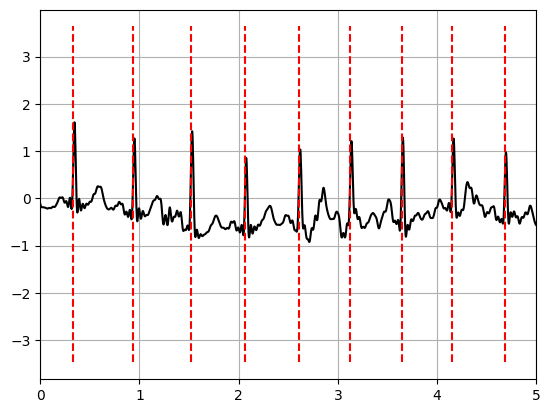

In [214]:
plt.plot(tvec, filtered_ecg, color="black")
plt.vlines(
    tvec[peak_inds],
    ymin=filtered_ecg.min(),
    ymax=filtered_ecg.max(),
    colors="red",
    ls="--",
)
plt.xlim([0, 5])
plt.grid(True)

## Bonus: Real-time Abnormality Identification

1. Define criteria to identify abnormalities based on **RR intervals** (time between consecutive peaks). Use criteria such as:
   - If **two consecutive RR intervals differ by more than 20%**, classify it as an abnormal beat.
   - If the **heart rate falls outside the normal range (60-100 BPM)**, classify it as abnormal.
2. Write a function to **identify and flag abnormal beats** based on your criteria.

---







In [ ]:
rr_intervals = np.diff(peak_inds) / fs
rr_intervals[:10]

array([0.60555556, 0.58055556, 0.54722222, 0.54166667, 0.51666667,
       0.51944444, 0.51111111, 0.52777778, 0.525     , 0.51388889])

In [259]:
[
    np.mean(rr_intervals),
    np.median(rr_intervals),
]

[np.float64(0.7577074542897329), np.float64(0.5805555555555556)]

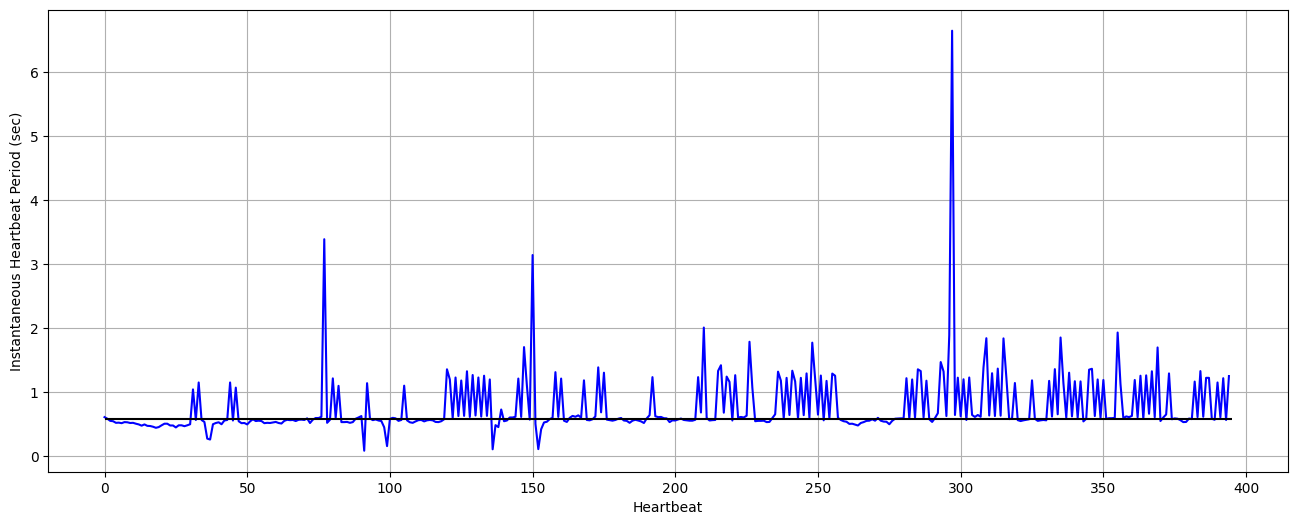

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(rr_intervals, "b")
plt.grid(True)
plt.xlabel("Heartbeat")
plt.ylabel("Instantaneous Heartbeat Period (sec)")
plt.hlines(np.median(rr_intervals), xmin=0, xmax=len(rr_intervals), colors="black")
# plt.xlim([0, 125])

In [260]:
instant_bpm = 1.0 / rr_intervals * 60.0

In [264]:
def is_abnormal_beat(
    instant_bpm: np.array, normal_min_bpm: float = 60.0, normal_max_bpm: float = 100.0
) -> np.array:
    return np.nonzero((instant_bpm < normal_min_bpm) | (instant_bpm > normal_max_bpm))


is_abnormal = is_abnormal_beat(instant_bpm, normal_min_bpm=40, normal_max_bpm=120)[0]

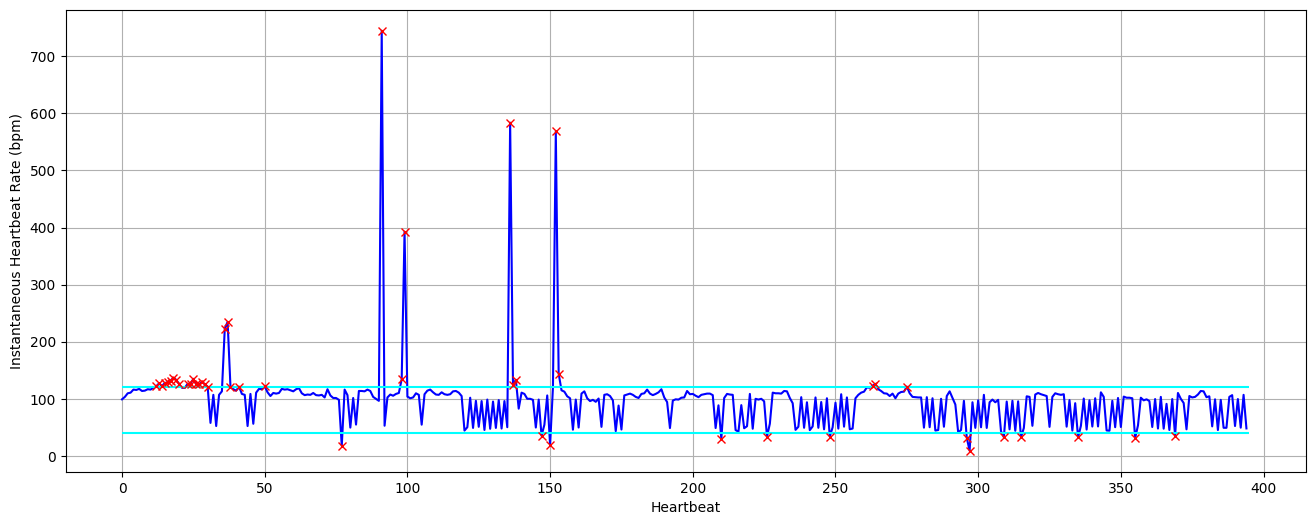

In [267]:
plt.figure(figsize=(16, 6))
plt.plot(instant_bpm, "b")
plt.grid(True)
plt.xlabel("Heartbeat")
plt.ylabel("Instantaneous Heartbeat Rate (bpm)")
plt.hlines([40, 120], xmin=0, xmax=len(instant_bpm), color="cyan", ls="-")
plt.plot(is_abnormal, instant_bpm[is_abnormal], "x", color="red")
plt.show()
# plt.xlim([0, 125])